# Pipelines & Imbalanced Data

In [64]:
import string
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

## Loading Dataset

https://www.kaggle.com/datasets/saurabhbagchi/dish-network-hackathon?select=Train_Dataset.csv

In [5]:
data = pd.read_csv("../data/workflow/Train_Dataset.csv")
data.head()

C:\Users\luan.barbosa\AppData\Local\Temp\ipykernel_10204\884177374.py:1: DtypeWarning: Columns (1,7,8,16,17,18,19,20,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/workflow/Train_Dataset.csv")


,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957,1062,6123,383,NaN,1,1,0,Sales,2.0,2.0,6.0,17.0,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250,1.0,0.0,1.0,NaN,0.0,15282,1826.55,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162,4129,7833,21,0.0,1,0,1,NaN,2.0,2.0,3.0,10.0,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000,0.0,0.0,1.0,0.0,1.0,59527.35,2788.2,Alone,Service,Graduation dropout,W,Male,CL,Family,0.0228,16790,5102,NaN,331,NaN,1,0,0,Realty agents,2.0,2.0,4.0,NaN,Yes,Yes,Self-employed,NaN,0.552795,0.329655,0.0742,277.0,0.0,0
3,12188929,15750,0.0,0.0,1.0,1.0,0.0,53870.4,2295.45,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,23195,365243,NaN,775,NaN,1,0,0,NaN,2.0,3.0,2.0,15.0,Yes,Yes,XNA,NaN,0.135182,0.631355,NaN,1700.0,3.0,0
4,12133385,33750,1.0,0.0,1.0,0.0,2.0,133988.4,3547.35,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,11366,2977,5516,4043,6.0,1,0,0,Laborers,4.0,1.0,3.0,NaN,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355639,0.2021,674.0,1.0,0


In [14]:
data.shape

(121856, 40)

In [6]:
data.describe()

,ID,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Score_Source_1,Score_Source_2,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
count,1.218560e+05,118275.000000,118232.000000,118221.000000,118195.000000,118218.000000,41761.000000,121856.000000,121856.000000,121856.000000,119446.000000,119447.000000,119428.000000,118193.000000,53021.000000,116170.000000,59928.000000,118192.000000,103316.000000,121856.000000
mean,1.216093e+07,0.342854,0.332262,0.499175,0.692060,0.417779,12.157324,0.999992,0.200499,0.281201,2.154329,2.030038,3.159736,12.063100,0.501213,0.518625,0.117428,962.106056,1.891082,0.080792
std,3.517694e+04,0.474665,0.471026,0.500001,0.461644,0.728802,12.056079,0.002865,0.400375,0.449587,0.912686,0.504407,1.759045,3.280695,0.211204,0.740248,0.107974,827.976726,1.861921,0.272517
min,1.210000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.014568,0.000005,0.000000,0.000000,0.000000,0.000000
25%,1.213046e+07,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,10.000000,0.333481,0.390164,0.057700,272.000000,0.000000,0.000000
50%,1.216093e+07,0.000000,0.000000,0.000000,1.000000,0.000000,9.000000,1.000000,0.000000,0.000000,2.000000,2.000000,3.000000,12.000000,0.504657,0.564978,0.088700,755.000000,1.000000,0.000000
75%,1.219139e+07,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,1.000000,0.000000,1.000000,3.000000,2.000000,5.000000,14.000000,0.673890,0.664011,0.148500,1570.000000,3.000000,0.000000
max,1.222186e+07,1.000000,1.000000,1.000000,1.000000,19.000000,69.000000,1.000000,1.000000,1.000000,16.000000,3.000000,6.000000,23.000000,0.945741,100.000000,1.000000,4185.000000,22.000000,1.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121856 entries, 0 to 121855
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID                          121856 non-null  int64  
 1   Client_Income               118249 non-null  object 
 2   Car_Owned                   118275 non-null  float64
 3   Bike_Owned                  118232 non-null  float64
 4   Active_Loan                 118221 non-null  float64
 5   House_Own                   118195 non-null  float64
 6   Child_Count                 118218 non-null  float64
 7   Credit_Amount               118224 non-null  object 
 8   Loan_Annuity                117044 non-null  object 
 9   Accompany_Client            120110 non-null  object 
 10  Client_Income_Type          118155 non-null  object 
 11  Client_Education            118211 non-null  object 
 12  Client_Marital_Status       118383 non-null  object 
 13  Client_Gender 

In [9]:
X = data.drop(columns=["Default", "ID"])
y = data.Default

In [10]:
print(y.value_counts())
y.value_counts(normalize=True)

Default
0    112011
1      9845
Name: count, dtype: int64


Default
0    0.919208
1    0.080792
Name: proportion, dtype: float64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
X_train.dtypes

Client_Income                  object
Car_Owned                     float64
Bike_Owned                    float64
Active_Loan                   float64
House_Own                     float64
Child_Count                   float64
Credit_Amount                  object
Loan_Annuity                   object
Accompany_Client               object
Client_Income_Type             object
Client_Education               object
Client_Marital_Status          object
Client_Gender                  object
Loan_Contract_Type             object
Client_Housing_Type            object
Population_Region_Relative     object
Age_Days                       object
Employed_Days                  object
Registration_Days              object
ID_Days                        object
Own_House_Age                 float64
Mobile_Tag                      int64
Homephone_Tag                   int64
Workphone_Working               int64
Client_Occupation              object
Client_Family_Members         float64
Cleint_City_

In [ ]:
# Unfortunately we get an error here!
X_train["Client_Income"].astype(float)

In [17]:
col_to_fix = ["Score_Source_3",
              "Client_Income",
              "Credit_Amount",
              "Loan_Annuity",
              "Age_Days",
              "Employed_Days",
              "Registration_Days",
              "ID_Days",
              "Population_Region_Relative"
             ]

## Building the pipeline and fixing that type!

In [20]:
print(string.punctuation)
print(string.ascii_letters)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ


In [21]:
string.punctuation.replace(".", "") + string.ascii_letters

'!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [22]:
def clean_df(X):
    def clean_value(value):
        unwanted_char = string.punctuation.replace(".", "") + string.ascii_letters
        for tag in unwanted_char:
            value = value.replace(tag, "")
        value = np.nan if not value else value
        return float(value)
    X = pd.DataFrame(X)
    X = X.astype(str).map(clean_value)
    return X

In [27]:
cleaner = FunctionTransformer(clean_df)

type_cleaner = ColumnTransformer(
    [("type_cleaner", cleaner, col_to_fix)],
    remainder="passthrough"
).set_output(transform="pandas")

In [28]:
type_cleaner.fit_transform(X_train)

,type_cleaner__Score_Source_3,type_cleaner__Client_Income,type_cleaner__Credit_Amount,type_cleaner__Loan_Annuity,type_cleaner__Age_Days,type_cleaner__Employed_Days,type_cleaner__Registration_Days,type_cleaner__ID_Days,type_cleaner__Population_Region_Relative,remainder__Car_Owned,remainder__Bike_Owned,remainder__Active_Loan,remainder__House_Own,remainder__Child_Count,remainder__Accompany_Client,remainder__Client_Income_Type,remainder__Client_Education,remainder__Client_Marital_Status,remainder__Client_Gender,remainder__Loan_Contract_Type,remainder__Client_Housing_Type,remainder__Own_House_Age,remainder__Mobile_Tag,remainder__Homephone_Tag,remainder__Workphone_Working,remainder__Client_Occupation,remainder__Client_Family_Members,remainder__Cleint_City_Rating,remainder__Application_Process_Day,remainder__Application_Process_Hour,remainder__Client_Permanent_Match_Tag,remainder__Client_Contact_Work_Tag,remainder__Type_Organization,remainder__Score_Source_1,remainder__Score_Source_2,remainder__Social_Circle_Default,remainder__Phone_Change,remainder__Credit_Bureau
4664,0.675413,22500.0,94050.00,3729.60,NaN,2686.0,2928.0,4258.0,0.026392,1.0,0.0,1.0,1.0,0.0,Relative,Service,Secondary,S,Male,NaN,Home,3.0,1,1,1,Sales,1.0,2.0,5.0,13.0,Yes,Yes,Business Entity Type 3,0.366184,0.515763,0.1464,528.0,0.0
99005,0.403142,13500.0,67500.00,1780.65,9921.0,551.0,776.0,1346.0,0.026392,0.0,0.0,0.0,0.0,0.0,Alone,Service,Graduation,M,Male,CL,Home,NaN,1,1,1,Core,2.0,2.0,2.0,14.0,Yes,Yes,Bank,NaN,0.591244,0.2619,338.0,2.0
48107,0.157595,10350.0,13940.55,769.05,10475.0,3637.0,10241.0,3158.0,0.020246,0.0,1.0,1.0,1.0,2.0,Alone,NaN,Secondary,M,Male,CL,Family,NaN,1,0,0,Sales,4.0,3.0,4.0,7.0,Yes,Yes,Self-employed,0.454473,0.319012,NaN,1040.0,7.0
97976,NaN,14850.0,72000.00,3050.55,22194.0,365243.0,8110.0,5256.0,0.072508,0.0,0.0,0.0,1.0,0.0,Alone,Retired,Secondary,S,Male,CL,Home,NaN,1,0,1,NaN,1.0,1.0,2.0,NaN,Yes,Yes,XNA,NaN,0.631997,0.2598,334.0,0.0
78034,0.560284,11250.0,63450.00,NaN,12924.0,285.0,7029.0,4648.0,0.014520,0.0,0.0,0.0,0.0,0.0,Alone,Service,Junior secondary,D,Female,CL,Family,NaN,1,0,0,Laborers,1.0,2.0,4.0,6.0,Yes,No,Business Entity Type 2,0.172293,0.229854,NaN,1588.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93313,NaN,14400.0,63448.20,2471.40,11396.0,1584.0,4586.0,NaN,NaN,1.0,1.0,0.0,1.0,1.0,Relative,Commercial,Secondary,M,Female,CL,Home,22.0,1,0,1,Laborers,3.0,2.0,2.0,14.0,Yes,Yes,Industry: type 4,NaN,0.117043,NaN,323.0,NaN
24114,NaN,11250.0,23985.00,2336.40,23171.0,365243.0,5390.0,4552.0,0.009334,0.0,1.0,0.0,1.0,0.0,Alone,Retired,Secondary,NaN,NaN,CL,Home,NaN,1,0,0,NaN,2.0,2.0,5.0,13.0,Yes,Yes,XNA,NaN,0.540016,0.0938,764.0,1.0
14180,NaN,18000.0,58476.60,2331.90,20951.0,3479.0,8343.0,4050.0,0.006233,0.0,1.0,1.0,1.0,0.0,Alone,NaN,Secondary,M,Female,NaN,Home,NaN,1,0,0,Laborers,2.0,2.0,3.0,15.0,Yes,Yes,Business Entity Type 3,NaN,0.443989,NaN,12.0,NaN
105783,0.812823,4500.0,22500.00,1613.25,16056.0,1233.0,3691.0,4327.0,0.010556,0.0,1.0,1.0,1.0,0.0,Alone,Service,Secondary,M,Male,CL,Home,NaN,1,1,1,Laborers,2.0,3.0,4.0,15.0,Yes,Yes,Business Entity Type 3,0.675231,0.573423,0.1732,2750.0,0.0


In [30]:
num_preproc = Pipeline([
    ("num_imputer", SimpleImputer(strategy="constant", fill_value=0.)),
    ("scaler", StandardScaler())
])

In [31]:
cat_preproc = Pipeline([
    ("cat_imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [32]:
preproc = ColumnTransformer([
    ("num_tr", num_preproc, make_column_selector(dtype_include=["float64", "int64"])),
    ("cat_tr", cat_preproc, make_column_selector(dtype_include=["object"]))
])

In [33]:
clean_preproc = Pipeline([
    ("cleaner", type_cleaner),
    ("preprocessing", preproc)
])

In [35]:
pipe = Pipeline([
    ("clean_preproc", clean_preproc),
    ("classifier", LogisticRegression(max_iter=1000))
])

pipe

,steps,"[('clean_preproc', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('cleaner', ...), ('preprocessing', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('type_cleaner', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [37]:
cross_val_score(pipe, X_train, y_train).mean()

np.float64(0.919166221589092)

In [39]:
cv = StratifiedKFold(n_splits=5)

cross_val_score(pipe, X_train, y_train, cv=cv).mean()

np.float64(0.919166221589092)

In [40]:
cv = StratifiedKFold(n_splits=5)
cross_val_score(pipe, X_train, y_train, cv=cv, scoring="average_precision").mean()

np.float64(0.17780604538717706)

In [41]:
pipe.fit(X_train, y_train)

,steps,"[('clean_preproc', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('cleaner', ...), ('preprocessing', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('type_cleaner', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


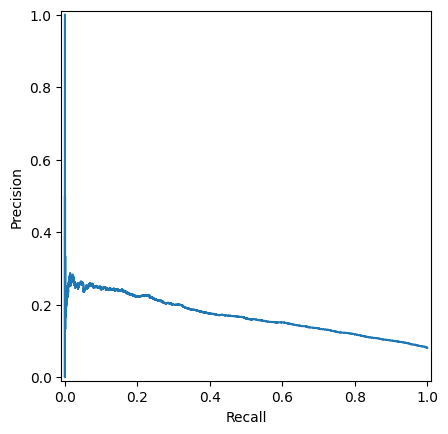

In [50]:
y_pred_prob = pipe.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## Trying a more complex model

In [53]:
pipe = Pipeline([
    ("cleaner", type_cleaner),
    ("preprocessing", preproc),
    ("classifier", RandomForestClassifier())
])

pipe

,steps,"[('cleaner', ...), ('preprocessing', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('type_cleaner', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [54]:
cv = StratifiedKFold(n_splits=5)
cross_val_score(pipe, X_train, y_train, cv=cv, scoring="average_precision").mean()

np.float64(0.3538651373632094)

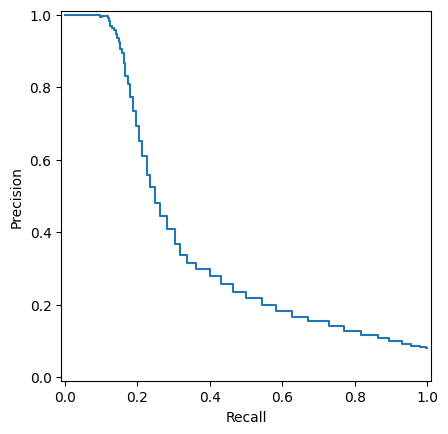

In [55]:
pipe.fit(X_train, y_train)
y_pred_prob = pipe.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

In [56]:
# Let's take the class imbalance into account

pipe = Pipeline([
    ("cleaner", type_cleaner),
    ("preprocessing", preproc),
    ("classifier", RandomForestClassifier(class_weight="balanced"))
])

cv = StratifiedKFold(n_splits=5)
cross_val_score(pipe, X_train, y_train, cv=cv, scoring="average_precision").mean()

np.float64(0.3620957855107587)

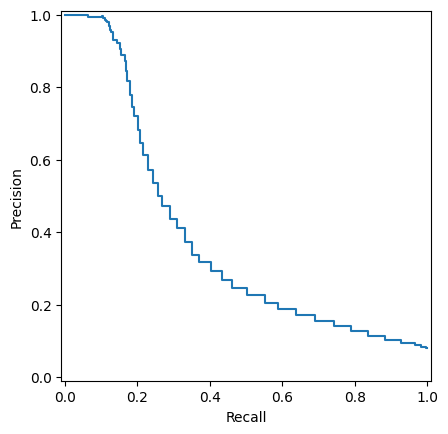

In [58]:
pipe.fit(X_train, y_train)
y_pred_prob = pipe.predict_proba(X_test)[:,1]


precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## Model Calibration

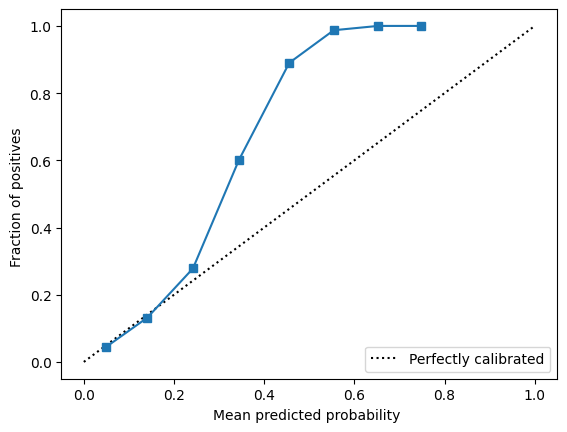

In [61]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

disp = CalibrationDisplay(prob_true, prob_pred, y_pred_prob)
disp.plot()

In [62]:
calibrated_clf = CalibratedClassifierCV(pipe, cv=cv)
calibrated_clf.fit(X_train, y_train)

,estimator,Pipeline(step...'balanced'))])
,method,'sigmoid'
,cv,StratifiedKFo...shuffle=False)
,n_jobs,None
,ensemble,'auto'
,transformers,"[('type_cleaner', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


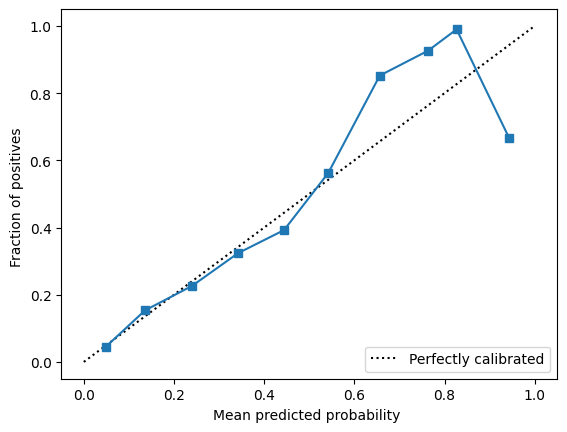

In [65]:
y_pred_prob = calibrated_clf.predict_proba(X_test)[:,1]

prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

disp = CalibrationDisplay(prob_true, prob_pred, y_pred_prob)
disp.plot()

In [66]:
# N.B. This can take quite some time to run!
cv = StratifiedKFold(n_splits=5)
cross_val_score(calibrated_clf, X_train, y_train, cv=cv, scoring="average_precision").mean()

np.float64(0.3764474361091228)

## Next Steps

We have a calibrated model, but our job is not over! If we're not satisfied with the performances we can perform:
- Parameter Tuning (Grid Search)
- Try even more advanced models
- Perform Oversampling or Undersampling

In [67]:
X_train_preproc = clean_preproc.fit_transform(X_train)

print(X_train_preproc.shape)
print(y_train.value_counts())

(97484, 151)
Default
0    89608
1     7876
Name: count, dtype: int64


### Oversampling - SMOTE

In [68]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preproc, y_train)

print(X_train_res.shape)
print(y_train_res.shape)
y_train_res.value_counts()

(179216, 151)
(179216,)


Default
0    89608
1    89608
Name: count, dtype: int64

### Undersampling - Random Under Sampler

In [69]:
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_preproc, y_train)

print(X_train_res.shape)
print(y_train_res.shape)
y_train_res.value_counts()

(15752, 151)
(15752,)


Default
0    7876
1    7876
Name: count, dtype: int64

### Undersampling - Tomek Link

In [70]:
tl = TomekLinks()
X_train_res, y_train_res = tl.fit_resample(X_train_preproc, y_train)

print(X_train_res.shape)
print(y_train_res.shape)
y_train_res.value_counts()

(95977, 151)
(95977,)


Default
0    88101
1     7876
Name: count, dtype: int64